# 🏨 **Hotel Cancel Culture - Time Series Modeling & Forecasting**

---

**Forecasting Cancellations**

> * **Goal:** Forecast cancellations for the given hotel data
> * **Why:** Predictions only work on preexisting reservations
    * *How can we forecast occupancy without depending on preexisting reservations?*
> * **How:** Using probabilities generated from prior classification modeling to forecast future cancellations

---

# ***OUT OF ORDER - PENDING UPDATES DUE TO REPOSITORY CHANGES***

In [1]:
raise Exception('This notebook is out of order and will not run.')

Exception: This notebook is out of order and will not run.

# **Imports**

In [1]:
## JNB tool to reload functions when called
%load_ext autoreload
%autoreload 2

In [ ]:
## Enabling access to custom functions in separate directory

# Import necessary modules
import os
import sys

# Construct the absolute path to the 'src' directory
src_path = os.path.abspath(os.path.join('..', 'src'))

# Append the path to 'sys.path'
if src_path not in sys.path:
    sys.path.append(src_path)

import db_utils, eda
import time_series_modeling as tsm

In [2]:
## Data Handling
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt

## Time Series Modeling
import statsmodels.tsa.api as tsa
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pmd
from pmdarima.arima import ndiffs, nsdiffs

In [3]:
## Settings
%matplotlib inline
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 50)

# **Reading Data**

---

**Reading Data and Setting the Datetime Index**

> I will import the data I cleaned and prepped in advance for my modeling processes.
>
> I created an `arrival_date` column during the prep process containing the arrival date as a datetime object. Using this feature, I will reset my index to enable the time series modeling.

---

In [4]:
## Reading data and setting DT index
source = '../data/data_probs.pickle'
data = pd.read_pickle(source, compression = "gzip")
data = data.set_index(data['arrival_date'])
data

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,agent_group,arrival_date,arrival_day,cxl_probability
arrival_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-01,Resort Hotel,0,342,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,0,0,0,C,3,No Deposit,0,Transient,0.00,0,0,2015-07-01,999,2015-07-01,Wednesday,0.04
2015-07-01,Resort Hotel,0,737,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,0,0,0,C,4,No Deposit,0,Transient,0.00,0,0,2015-07-01,999,2015-07-01,Wednesday,0.01
2015-07-01,Resort Hotel,0,7,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,0,0,0,A,0,No Deposit,0,Transient,75.00,0,0,2015-07-02,999,2015-07-01,Wednesday,0.01
2015-07-01,Resort Hotel,0,13,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,0,0,0,A,0,No Deposit,0,Transient,75.00,0,0,2015-07-02,999,2015-07-01,Wednesday,0.02
2015-07-01,Resort Hotel,0,14,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,0,0,0,A,0,No Deposit,0,Transient,98.00,0,1,2015-07-03,240,2015-07-01,Wednesday,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-30,City Hotel,0,23,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,0,0,0,A,0,No Deposit,0,Transient,96.14,0,0,2017-09-06,999,2017-08-30,Wednesday,0.01
2017-08-31,City Hotel,0,102,August,35,31,2,5,3,0.00,0,BB,FRA,Online TA,0,0,0,E,0,No Deposit,0,Transient,225.43,0,2,2017-09-07,9,2017-08-31,Thursday,0.46
2017-08-31,City Hotel,0,34,August,35,31,2,5,2,0.00,0,BB,DEU,Online TA,0,0,0,D,0,No Deposit,0,Transient,157.71,0,4,2017-09-07,9,2017-08-31,Thursday,0.13


# **Resampling**

---

**Resampling the Arrival Dates**

> My dataset includes multiple reservations per day, which makes sense, but also impairs the modeling process.
>
> **I will resample the data as daily averages for the modeling and forecasting process.**
* *Daily resampling* allows me to view the data for all reservations for a given day.
* *Computing the average cancellations* provides a normalized value allowing for easy comparisons between dates (without having to consider other features, such as occupancy, demand, etc.).

arrival_date
2015-07-01   0.16
2015-07-02   0.61
2015-07-03   0.34
2015-07-04   0.49
2015-07-05   0.30
             ... 
2017-08-27   0.28
2017-08-28   0.30
2017-08-29   0.35
2017-08-30   0.30
2017-08-31   0.34
Freq: D, Name: is_canceled, Length: 793, dtype: float64

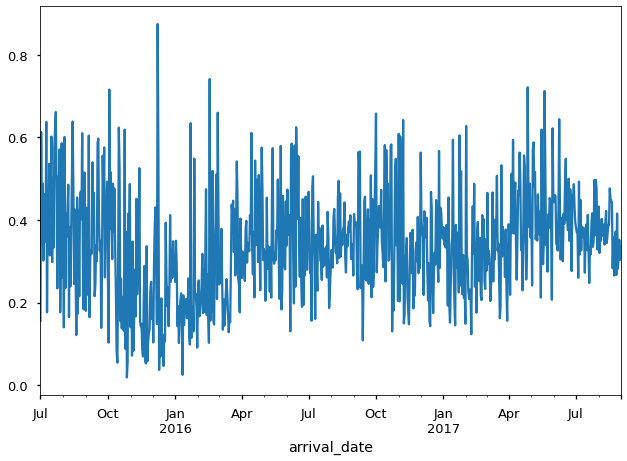

In [5]:
## Resampling for average daily cancellations
ts_avg = data['is_canceled'].resample('D').mean()
display(ts_avg)
ts_avg.plot();

In [6]:
## Subsetting data from 2016-17
ts_avg = ts_avg.loc["2016":'2017']
ts_avg

arrival_date
2016-01-01   0.25
2016-01-02   0.35
2016-01-03   0.29
2016-01-04   0.14
2016-01-05   0.19
             ... 
2017-08-27   0.28
2017-08-28   0.30
2017-08-29   0.35
2017-08-30   0.30
2017-08-31   0.34
Freq: D, Name: is_canceled, Length: 609, dtype: float64

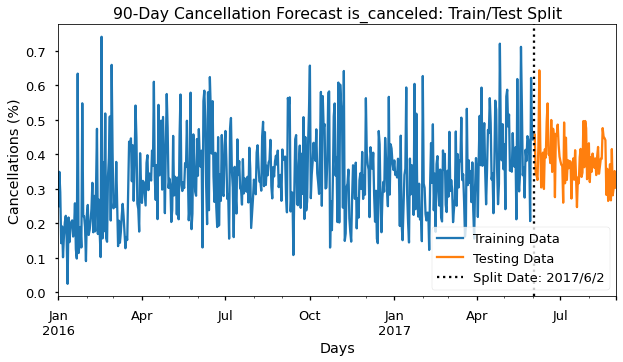

In [7]:
## Creating train/test split
split_dict = tsm.train_test_split(ts_avg, -90, xlabel="Days",
                                  ylabel="Cancellations (%)",
                                  title = "90-Day Cancellation Forecast");

In [8]:
## Inspecting results
split_dict['train']

arrival_date
2016-01-01   0.25
2016-01-02   0.35
2016-01-03   0.29
2016-01-04   0.14
2016-01-05   0.19
             ... 
2017-05-29   0.21
2017-05-30   0.62
2017-05-31   0.45
2017-06-01   0.44
2017-06-02   0.46
Freq: D, Name: is_canceled, Length: 519, dtype: float64

# **Seasonal Decomposition**

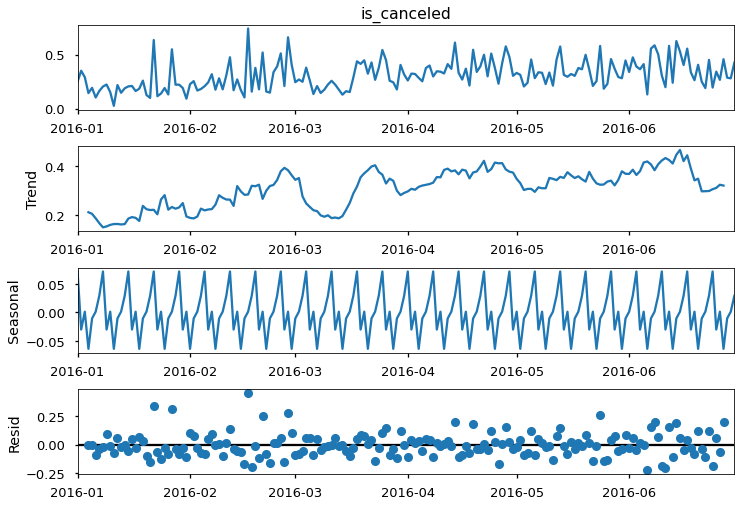

In [9]:
## Performing seasonal decomp to determine seasonality for modeling
decomp = tsa.seasonal_decompose(split_dict['train'].loc['01-2016':'06-2016'])
# decomp.seasonal.plot(figsize = (15,4));
decomp.plot();

---

**Seasonality**

> Based on the results of the seasonal decomposition, I see there is a weekly seasonality (there are four peaks/valleys per month). This matches up with my expectation that there would be regular stay/cancel patterns based on the day of the week a reservation is due to arrive.
>
> Now that I determined the seasonality, I will use it as an argument in my workflow function (created from a prior time series modeling project).

---

# **Full Workflow**

---

**I will use a functionalized workflow from my prior time series modeling work to perform my analysis and generate my forecast.**
>
> This function:
>  * Splits the data at a threshold based on either a percentage or specific period (in this case, the past 90 days)
>  * Performs SARIMA modeling via PMD's Auto-Arima to determine the optimal hyperparameters and Statsmodels's SARIMAX model for the forecasting.
>  * Generates forecasted data and 95% confidence interval for the time period set in the train/test split step.
>  * Saves the train/test split data; forecast and confidence interval data; and associated visualizations to a dictionary for review.

---

In [10]:
## Running the workflow
results = tsm.ts_modeling_workflow(ts_avg, threshold = -90, xlabel='Dates',
                                   ylabel = 'Cancellations (%)',
                                   title = 'Forecasted Cancellations', m=7,
                                   show_vis=False)

In [11]:
## Inspecting the keys for the resulting dictionary
results.keys()

dict_keys(['forecasted_data', 'model', 'forecast_length', 'model_metrics', 'model_visuals'])

In [12]:
##Rounding forecast data to nearest whole numbers
results['forecasted_data'] = (results['forecasted_data']*100).round(0)
results['forecasted_data']

,Lower CI,Upper CI,Forecast
2017-09-01,17.00,59.00,38.00
2017-09-02,17.00,59.00,38.00
2017-09-03,11.00,54.00,32.00
2017-09-04,13.00,55.00,34.00
2017-09-05,12.00,54.00,33.00
...,...,...,...
2017-11-25,11.00,63.00,37.00
2017-11-26,6.00,58.00,32.00
2017-11-27,8.00,60.00,34.00
2017-11-28,7.00,59.00,33.00


In [13]:
## Identifying average for the 90-day window
results['forecasted_data'].mean().round(0)

Lower CI   12.00
Upper CI   59.00
Forecast   35.00
dtype: float64

---

**Forecast Confidence Interval**

> Based on my time series model, the hotels may expect an average of 35% daily cancellations over the next 90 days. However, there is a confidence interval of  +/- 23.5%.
>
> **This large confidence interval limits the usefulness of the forecast due to the risk of errors.** If a hotel would overbook with the expectation of the average 35% cancellation rate, only to have a 45%+ cancellation rate, it would force the hotel to relocate a large number of reservations. As relocated reservations incur significant costs (both for paying for the relocated night as well as potentially losing future business), the risk of overbooking is too great with this model's forecast.

**Reducing Risk**

> The next step of this analysis would be adjusting the model to reduce variability of the forecast results. The adjustments may include:
 * Adding additional data (holidays, presence/absence of additional demand generators)
 * Adjusting threshold values for train/test split

**Looking Forward**

> My next steps will be to evaluate the impact of shorter- and longer-term thresholds for my training data. Initially, I started with a 90-day evaluation; I will reevaluate the performance using several different thresholds to compare the impact of using different windows for forecasting.

In [14]:
## Testing new thresholds for train/test split and forecast

thresholds = [-3, -7, -15, -30, -60, -90, -180]

ints = {}

for threshold in thresholds:
    results = tsm.ts_modeling_workflow(ts_avg, threshold = threshold, xlabel='Dates',
                                       ylabel = 'Cancellations (%)',
                                       title = 'Forecasted Cancellations',
                                       m=7,show_vis=False)
    
    ints[threshold*-1] = [round(results['forecasted_data']['Lower CI'].mean(), 2)*100,
                  round(results['forecasted_data']['Forecast'].mean(), 2)*100,
                  round(results['forecasted_data']['Upper CI'].mean(), 2)*100]

C:\Users\bmcca\anaconda3\envs\test_intel_env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
## Combining results into DataFrame for analysis and display

results_df = pd.DataFrame.from_dict(ints, orient = 'index')
results_df.rename(columns = {0: 'Lower CI', 1: 'Average', 2:'Upper CI'},
                 inplace=True)

results_df['CI Difference'] = (results_df['Upper CI'] - results_df['Lower CI'])

results_df.index.rename('Days Out', inplace=True)

results_df.style.background_gradient(subset = 'CI Difference', cmap='Reds')\
                                                            .format('{:.0f}%')

,Lower CI,Average,Upper CI,CI Difference
Days Out,,,,
3,15%,36%,57%,42%
7,14%,35%,57%,43%
15,15%,36%,57%,42%
30,13%,36%,58%,45%
60,13%,36%,59%,46%
90,12%,35%,59%,47%
180,8%,35%,62%,54%


---

**Interval Impacts**

> Despite changing the threshold levels, there is little improvement in the confidence intervals.

---

# **Results and Recommendations**

## Results

---

**Best Performance:** 3/7/15 day windows
  * Guests are less likely to cancel based on prior classification modeling
  * Confidence intervals slightly smaller than longer-term perspective.
  
**Worst Performance:** 180+ days
  * Strongest likelihood of cancellations based on prior models
  * Limited benefits for on-site teams
    * Sales may use it for longer-term planning, such as business account performances or group booking trends
    * Operations may use it to identify potential spikes in occupancy/demand, guiding staffing decisions or intensive projects (such as deep cleaning, system updates, or renovations)
    
---

## Recommendations

**In my opinion, the best results came from using a 90-day threshold to forecast cancellations.**

> * **Short forecasts best for Operations:** creating schedules; ordering supplies; other time-sensitive decisions.
>  * *Limited benefit for Sales due to short window of opportunity to book groups or push business travel.*
>
>
> * **Longer Forecasts best for Sales:** booking groups and monitoring pickup; performing sales calls for targeted businesses.
>  * *Less beneficial for Operations - scheduling, purchasing supplies based on occupancy and demand.*

**Pros and Cons Based on Personal Experience/Opinions**

| Time Period (Days) | Pros | Cons | Best Use |
| --- | --- | --- | --- |
| 3, 7, 15 | Increased accuracy | Less reaction time | Operations-related decision making; scheduling |
| 30, 60, 90 | Actionable time window for Sales (group sales especially) | Less accurate; more of a "rough idea" | On-Site Sales & Marketing strategy |
| 180+ | Can identify problem areas; trends/events; and focus areas | Numbers can and will change based on bookings/cancellations | Long-term revenue management

---

## Caveats

---

***These results may not generalize well for other hotels and/or different times. They are meant to be guidelines and ideas for hotels to adapt to their needs.***

As mentioned in my prior classification modeling notebook, these results are specific to these two hotels for this given time period.

Each hotel is different: target clientele, amenities, locations, etc.. Additionally, larger market trends and unexpected events (locally or globally) may have positive and/or negative impacts on cancellations.

---

## Future Work

---

**Future work will include:**

* Multivariate time series modeling via variable autoregression (VAR)


* Specific breakdowns:
    * Guest type: transient, leisure, groups
    * Room type: several different room types
    * Hotel type: resort vs. city hotels


* Model deployment for hotel-specific results
---

# **Conclusion**

---

**Thank you for your interest in my work.**

This concludes my exploration of the hotel booking dataset via univariate time series analysis.

While the results are not as exact as I would prefer, I feel confident in their current state and look forward to performing additional analysis via multivariate time series modeling as well as model deployment.

**I welcome any comments or questions! Please feel free to contact me.**

---
